This notebook is as an appendum to the talk given at PyCon 2015: http://www.pycon.se/#pieters
- [slides](http://www.slideshare.net/roelofp/deep-learning-as-a-catdog-detector)
- [video recording](https://www.youtube.com/watch?v=wBKfGaakFp8)

In [47]:
from IPython.display import Image
Image(url='http://image.slidesharecdn.com/catvsdogdlpycon15se-150512122612-lva1-app6891/95/deep-learning-as-a-catdog-detector-1-638.jpg?cb=1431434162')

Libraries we will be using:
- sckikit-learn (machine learning) http://scikit-learn.org 
- caffe (deep learning) - for training deep neural nets (for today: loading a pre-trained one) http://caffe.berkeleyvision.org 
- theano (efficient gpu-powered math) http://www.deeplearning.net/software/theano/ 
- pylearn2 (wrapper on top of theano) http://deeplearning.net/software/pylearn2/
- ipython notebook http://ipython.org/notebook.html

Want to know more?
- http://deeplearning.net/tutorial/

or drop by the [Deep Learning meetup](www.meetup.com/Stockholm-Deep-Learning-Meetup/) if you're around in Stockholm

on we go...

---

# CAFFE AND IMAGENET

First we start by importing all libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Make sure that caffe is on the python path
# this ipynb file works from directory: <...>/caffe/examples/
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = '../models/bvlc_reference_caffenet/deploy.prototxt'
PRETRAINED = '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
IMAGE_FILE = 'images/cat.jpg'

We will use a pretrained CNN model

pretrained Caffe models can be downloaded from the Model Zoo, ([here](http://caffe.berkeleyvision.org/model_zoo.html)) and ([here](https://github.com/BVLC/caffe/wiki/Model-Zoo)) 

We will be using the BVLC Reference CaffeNet model in models/bvlc_reference_caffenet: AlexNet trained on ILSVRC 2012, with a minor variation from the version as described in ([ImageNet classification with deep convolutional neural networks](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)) by Krizhevsky et al. in NIPS 2012. (Trained by Jeff Donahue @jeffdonahue)

If we havent't downloaded it, let's do so:

In [4]:
import os
if not os.path.isfile(PRETRAINED):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

lets pass the model to Caffe

In [5]:
caffe.set_mode_gpu() #change this to set_mode_cpu() if you don't have a gpu to work on
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

load an image:

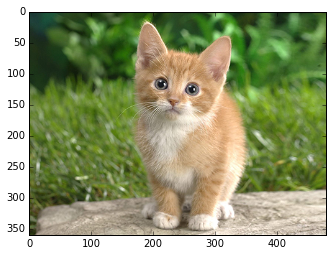

In [6]:
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)

the image gets loaded as a height x width x 3 channels matrix:

In [7]:
input_image.shape

(360, 480, 3)

lets do our first prediction on the input image

`net.predict()` takes any number of images, and formats them for the Caffe net automatically

prediction shape: (1000,)
predicted class: 281


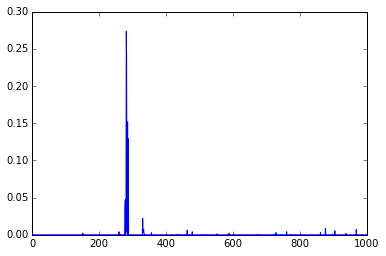

In [9]:
prediction = net.predict([input_image]) 
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax()

lets classify by the center crop alone by turning off oversampling:

prediction shape: (1000,)
predicted class: 281


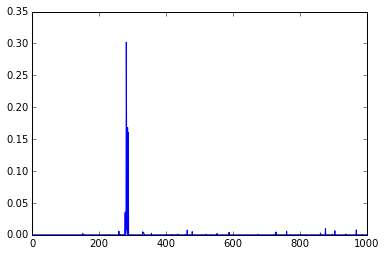

In [355]:
prediction = net.predict([input_image], oversample=False)
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax()

so lets get some labels to those predicted classes:

In [10]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02127052 lynx, catamount' 'n02123159 tiger cat'
 'n02123045 tabby, tabby cat' 'n02124075 Egyptian cat'
 'n02119789 kit fox, Vulpes macrotis']


so how does our net actually look like?
A picture says more than... you know what...

In [45]:
Image(url='http://image.slidesharecdn.com/22-01-15dlmeetup-150122111042-conversion-gate01/95/deep-learning-an-interactive-introduction-for-nlpers-62-638.jpg')

lets print the various layers:

In [11]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [21]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

for the purpose of this tutorial we will use the features of fully connected layer 6 (fc6) and extract these 4096 features for each image. So in essence transforming a training image into a feature set.

why fc6? no particular reason, more intuition than anything, as fc6 should be the least fitted to the final fc layer (fc8) which transforms 4096 features into a probabilty over the 1000 imagenet classes.

feel free to experiment yourself, and let me know your results :)

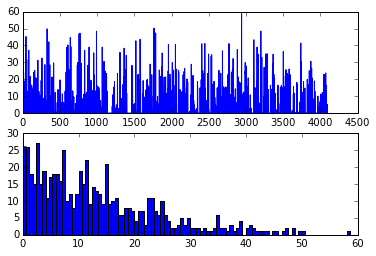

In [12]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

#Cat vs Dog time!

We will use the ([Kaggle dogs vs cats](kaggle.com/c/dogs-vs-cats)) competition's dataset, which contains 25k images of cats and dogs.

In [13]:
from glob import glob
basedir = '/mnt/pet/train/'
#load all files:
files = glob(basedir + '*.jpg')

In [14]:
files[0]

'/mnt/pet/train/dog.2231.jpg'

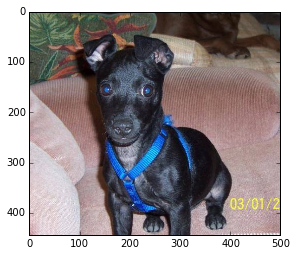

In [15]:
input_image = caffe.io.load_image(files[0])
plt.imshow(input_image)

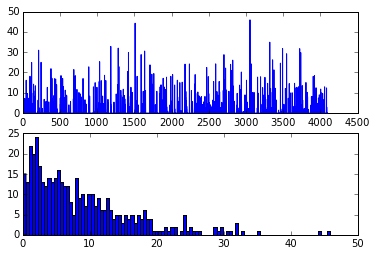

In [18]:
#FEATURE OF FC6 (ONE BEFORE FINAL FC LAYER)
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

prediction shape: (1000,)
predicted class: 179


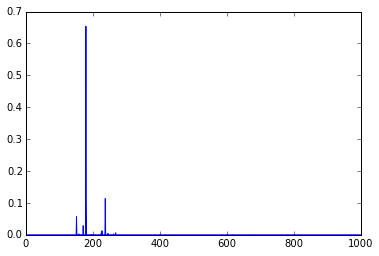

In [19]:
#s classify by the center crop alone by turning off oversampling. 
prediction = net.predict([input_image], oversample=False)
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax()

In [20]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02093256 Staffordshire bullterrier, Staffordshire bull terrier'
 'n02107312 miniature pinscher'
 'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier'
 'n02085620 Chihuahua' 'n02091032 Italian greyhound']


Googling these dogs, our image might be a miniature pinscher, so class #2, not bad...

---

# VISUALIZE LAYERS

Lets see how our already trained (we loaded a pre-trained net remember?) layers look like.

But before we do so lets see how we can load an image into the network:

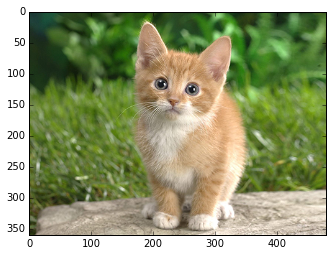

In [29]:
#normal loading/showing of image:
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)

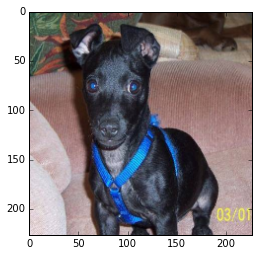

In [32]:
#show the data, or whats inside the actual first data blob which gets fed into the first layer:
plt.imshow(net.transformer.deprocess('data', net.blobs['data'].data[0]))

yes its out previous dog! :)

which looks like this:

In [36]:
# 'data' is the input blob name in the model definition, so we preprocess for that input.
caffe_input = np.asarray([net.transformer.preprocess('data', in_) for in_ in input_oversampled])
caffe_input

array([[[[ -54.16323853,  -56.55484009,  -53.93081665, ...,  -63.42398071,
           -50.97866821,  -42.82632446],
         [ -52.83608627,  -55.5880394 ,  -54.35561752, ...,  -59.63003159,
           -48.26577759,  -39.21109009],
         [ -54.42007446,  -55.31948853,  -55.19155884, ...,  -56.97085571,
           -45.43276596,  -36.91616058],
         ..., 
         [ -83.1065979 ,  -82.04116821,  -79.20718384, ...,   70.78599548,
            75.98324585,   85.99984741],
         [ -79.88394165,  -86.57925415,  -80.73062134, ...,   78.76939392,
            79.76548767,   82.11801147],
         [ -72.03530884,  -77.24429321,  -70.5909729 , ...,   86.47348022,
            86.65318298,   78.15414429]],

        [[ -59.23126602,  -61.46564102,  -59.24005508, ...,  -36.35724258,
           -14.76251793,   -2.41193175],
         [ -59.49786758,  -60.24982071,  -59.01739883, ...,  -29.34357262,
           -10.73126793,    2.49236512],
         [ -59.08185196,  -60.28887939,  -60.66583633, 

In [39]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

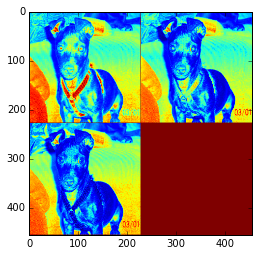

In [42]:
#or this as data in the blob, just before it gets pushed into the the actual first conv layer:
feat = net.blobs['data'].data[0, :36]
vis_square(feat, padval=1)

and like this in the first conv layer (the so called edge detectors):

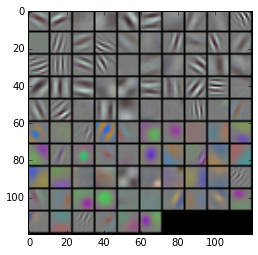

In [43]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

second conv layer:

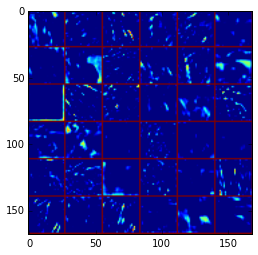

In [44]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

etc...

---

# RUN IMAGES THROUGH NET AND SAVE FEATURES

Now we know how the net operates, lets push all our training images through it. 
We use the fact that the network has already a pretty good idea of 1000 different classes of images, and will transform our WxHx3 channel pixel representation to a 4096 dimensional feature vector, by extracting the constructed features from the conv6 layer as we suggested earlier.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe


#from decaf.util import transform
#from decaf.scripts import imagenet
import logging
import numpy as np
from glob import glob
import matplotlib.image as mpimg
from random import shuffle
import pickle

# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = '../models/bvlc_reference_caffenet/deploy.prototxt'
PRETRAINED = '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
#IMAGE_FILE = 'images/cat.jpg'

import os
if not os.path.isfile(PRETRAINED):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet
    

def activate(net, im):
    input_image = caffe.io.load_image(im)
    # Resize the image to the standard (256, 256) and oversample net input sized crops.
    input_oversampled = caffe.io.oversample([caffe.io.resize_image(input_image, net.image_dims)], net.crop_dims)
    # 'data' is the input blob name in the model definition, so we preprocess for that input.
    caffe_input = np.asarray([net.transformer.preprocess('data', in_) for in_ in input_oversampled])
    # forward() takes keyword args for the input blobs with preprocessed input arrays.
    predicted = net.forward(data=caffe_input)
    # Activation of all convolutional layers and first fully connected
    feat = net.blobs['fc6'].data[0]
    return feat


def png_to_np(basedir, fetch_target=False):
    logging.getLogger().setLevel(logging.INFO)
    caffe.set_mode_gpu()
    net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

    files = glob(basedir + '*.png') #converted from original jpg
    if fetch_target:
        shuffle(files)
        # Sort the files so they match the labels
        target = np.array([1. if 'dog' in f.split("/")[-1] else 0.
                           for f in files],
                          dtype='float32')
    else:
        #Must sort the files for the test sort to assure order!
        files = sorted(files,
                       key=lambda x: int(x.split("/")[-1].split(".")[-2]))
    
    #HACK: limit to 100 files
    #files = files[:100]
    
    feature_info = activate(net, files[0])
    feature_count = feature_info.shape[0]
    feature_dtype = feature_info.dtype
    data = np.zeros((len(files), feature_count), dtype=feature_dtype)
    for n, im in enumerate(files):
        data[n, :] = activate(net, im)
        if n % 1000 == 0:
            print 'Reading in image', n
    if fetch_target:
        return data, target, files
    else:
        return data, files

In [290]:
x, y, filenames = png_to_np(
    '/mnt/pet/train/', fetch_target=True)
pickle.dump(x, open('saved_x_v2.pkl', 'wb'))
pickle.dump(y, open('saved_y_v2.pkl', 'wb'))
pickle.dump(filenames, open('saved_filenames_v2.pkl', 'wb'))

Reading in image 0
Reading in image 1000
Reading in image 2000
Reading in image 3000
Reading in image 4000
Reading in image 5000
Reading in image 6000
Reading in image 7000
Reading in image 8000
Reading in image 9000
Reading in image 10000
Reading in image 11000
Reading in image 12000
Reading in image 13000
Reading in image 14000
Reading in image 15000
Reading in image 16000
Reading in image 17000
Reading in image 18000
Reading in image 19000
Reading in image 20000
Reading in image 21000
Reading in image 22000
Reading in image 23000
Reading in image 24000


ok now we got our features saved as a pickle file we can move on...

---

#TRAIN MODEL ON TOP OF FEATURES

Now we got these features, we will train a RBM on top of it (see presentation slides+video for more details) to create a classifier which can seperate dog images from cat images, 
with the added benefit of deciding what "other" objects look like, ie: Does a particular individual look more like a dog or a cat? :)

we use pylearn2, a wrapper on top of theano. In the example below we run it for just 500 epochs:

In [396]:
from pylearn2.models import mlp
from pylearn2.costs.mlp.dropout import Dropout
from pylearn2.training_algorithms import sgd, learning_rule
from pylearn2.termination_criteria import EpochCounter
from pylearn2.datasets import DenseDesignMatrix
from pylearn2.train import Train
from pylearn2.train_extensions import best_params
from pylearn2.space import VectorSpace
import pickle
import numpy as np

def to_one_hot(l):
    out = np.zeros((len(l), len(set(l))))
    for n, i in enumerate(l):
        out[n, i] = 1.
    return out

x = pickle.load(open('saved_x_v2.pkl', 'rb'))
y = pickle.load(open('saved_y_v2.pkl', 'rb'))
filenames = pickle.load(open('saved_filenames_v2.pkl', 'rb'))
y = to_one_hot(y)
in_space = VectorSpace(dim=x.shape[1])
full = DenseDesignMatrix(X=x, y=y)

l1 = mlp.RectifiedLinear(layer_name='l1',
                         sparse_init=12,
                         dim=5000,
                         max_col_norm=1.)

l2 = mlp.RectifiedLinear(layer_name='l2',
                         sparse_init=12,
                         dim=5000,
                         max_col_norm=1.)

l3 = mlp.RectifiedLinear(layer_name='l3',
                         sparse_init=12,
                         dim=5000,
                         max_col_norm=1.)

output = mlp.Softmax(layer_name='y',
                     n_classes=2,
                     irange=.005)

layers = [l1, l2, l3, output]

mdl = mlp.MLP(layers,
              input_space=in_space)

lr = .0001
epochs = 500
trainer = sgd.SGD(learning_rate=lr,
                  batch_size=128,
                  learning_rule=learning_rule.Momentum(.5),
                  # Remember, default dropout is .5
                  cost=Dropout(input_include_probs={'l1': .8},
                               input_scales={'l1': 1.}),
                  termination_criterion=EpochCounter(epochs),
                  monitoring_dataset={'train': full})

watcher = best_params.MonitorBasedSaveBest(
    channel_name='train_y_misclass',
    save_path='saved_clf_v3.pkl')

velocity = learning_rule.MomentumAdjustor(final_momentum=.6,
                                          start=1,
                                          saturate=250)

decay = sgd.LinearDecayOverEpoch(start=1,
                                 saturate=250,
                                 decay_factor=lr*.05)

experiment = Train(dataset=full,
                   model=mdl,
                   algorithm=trainer,
                   extensions=[watcher, velocity, decay])

In [ ]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(x, y,
#                                                    test_size=.2,
#                                                    random_state=42)

# no sklearn.cross_validation > train_test_split
# own test/train split so we can also link filenames
splitter = round(len(x)*0.8)
X_train, X_test = x[:splitter], x[splitter:]
y_train, y_test = y[:splitter], y[splitter:]
filenames_train, filenames_test = filenames[:20000], filenames[20000:]

pickle.dump(X_train, open('saved_feat_x_train_v2.pkl', 'wb'))
pickle.dump(X_test, open('saved_feat_x_test_v2.pkl', 'wb'))
pickle.dump(y_train, open('saved_feat_y_train_v2.pkl', 'wb'))
pickle.dump(y_test, open('saved_feat_y_test_v2.pkl', 'wb'))
pickle.dump(filenames_train, open('saved_feat_filenames_train_v2.pkl', 'wb'))
pickle.dump(filenames_test, open('saved_feat_filenames_test_v2.pkl', 'wb'))

In [ ]:
trn = DenseDesignMatrix(X=X_train, y=y_train)
tst = DenseDesignMatrix(X=X_test, y=y_test)
trainer.monitoring_dataset={'valid': tst,
                            'train': trn}
experiment.main_loop()

Parameter and initial learning rate summary:
	l1_W: 9.99999974738e-05
	l1_b: 9.99999974738e-05
	l2_W: 9.99999974738e-05
	l2_b: 9.99999974738e-05
	l3_W: 9.99999974738e-05
	l3_b: 9.99999974738e-05
	softmax_b: 9.99999974738e-05
	softmax_W: 9.99999974738e-05
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 1.379007 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.432231 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_l1_col_norms_max
	train_l1_col_norms_mean
	train_l1_col_norms_min
	train_l1_max_x_max_u
	train_l1_max_x_mean_u
	train_l1_max_x_min_u
	train_l1_mean_x_max_u
	train_l1_mean_x_mean_u
	train_l1_mean_x_min_u
	train_l1_min_x_max_u
	train_l1_min_x_mean_u
	train_l1_min_x_min_u
	train_l1_range_x_max_u
	train_l1_range_x_mean_u
	train_l1_range_x_min_u
	train_l1_row_norms_max
	train_l1_row_norms_mean
	train_l1_row_norms_min
	train_l2_col_norms_max
	train_l2_col_norms_mean
	train_l2_col_norms_m

In [ ]:
trn = DenseDesignMatrix(X=X_train, y=y_train)
tst = DenseDesignMatrix(X=X_test, y=y_test)
trainer.monitoring_dataset={'valid': tst,
                            'train': trn}
experiment.main_loop()

Ive saved the output of the experiment as 2 log files so we can plot the results:

In [316]:
with open("logg.txt", "r") as ins:
    score_test = []
    for line in ins:
        if len(line) > 2:
            score_test.append(line.split()[1])
            
with open("logg2.txt", "r") as ins:
    score_train = []
    for line in ins:
        if len(line) > 2:
            score_train.append(line.split()[1])

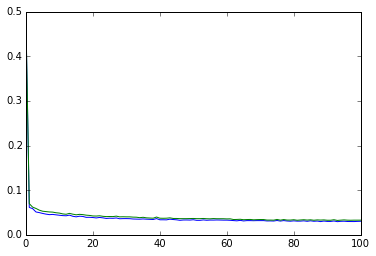

In [373]:
plt.plot(score_train)
plt.plot(score_test)

skipping the first iteration it becomes more clear the net error rate is still decreasing, so increasing the 500 epochs (taking an hour or so) to more should increase performance, at least until it will start overfitting (we would normally use a third dev set, to regulate this)

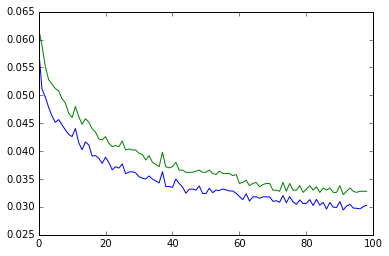

In [319]:
plt.plot(score_train[2:])
plt.plot(score_test[2:])

---

#PREDICTIONS

Ok now we got a working stacked RBM or Deeb Belief Net (DBN)
which we trained ourselves on features extracted from a pretrained CNN.

Time to do some predictions on images it hasnt seen yet:

In [51]:
import sys
import os
import numpy as np
import cPickle as pickle

from pylearn2.utils import serial
from theano import tensor as T
from theano import function

Using gpu device 0: GRID K520


In [52]:
print "loading model..."
model = serial.load('saved_clf_v2.pkl')

loading model...


In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe


#from decaf.util import transform
#from decaf.scripts import imagenet
import logging
import numpy as np
from glob import glob
import matplotlib.image as mpimg
from random import shuffle
import pickle

# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = '../models/bvlc_reference_caffenet/deploy.prototxt'
PRETRAINED = '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

def getfeat_single_image(image_path):
    logging.getLogger().setLevel(logging.INFO)
    caffe.set_mode_gpu()
    net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

      
    feature_info = activate(net, image_path)
    return feature_info

In [54]:
print "setting up symbolic expressions..."

X = model.get_input_space().make_theano_batch()
Y = model.fprop(X)
Y = T.argmax(Y, axis=1)

f = function([X], Y)

print "loading data and predicting..."

setting up symbolic expressions...
loading data and predicting...


In [57]:
feat = getfeat_single_image('images/cat.jpg') #run image through cnn > out: features of layer fc6
x = feat 
y = f([x]) #run feature through DBN > out: prediction
#y #0=cat
if y:
    print "WOOF!"
else:
    print "MEOW!"

MEOW!


In [58]:
feat = getfeat_single_image('images/dog.jpg')  #run image through cnn > out: features of layer fc6
x = feat
y = f([x]) #run feature through DBN > out: prediction
#y #1=dog
if y:
    print "WOOF!"
else:
    print "MEOW!"

WOOF!


In [367]:
#BATCH TEST
x = pickle.load(open('saved_feat_x_test_v2.pkl', 'rb'))
y = pickle.load(open('saved_feat_y_test_v2.pkl', 'rb'))
filenames = pickle.load(open('saved_feat_filenames_test_v2.pkl', 'rb'))

In [368]:
predicted = f(x)

In [369]:
#[0,1] to [1]
#[1,0] to [0]
out = np.zeros(len(y))
for n, i in enumerate(y):
    if i[1]:
        out[n] = 1
y = out

In [370]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['cat', 'dog']
print(classification_report(y, predicted, target_names=target_names))

             precision    recall  f1-score   support

        cat       0.96      0.98      0.97      2461
        dog       0.98      0.96      0.97      2539

avg / total       0.97      0.97      0.97      5000



97% accuracy, after but an hour of training, nice!

---

#CAT OR DOG TO THE TEST 

I uploaded a picture of myself to imgur, lets try it with another one now to see if they match up:

In [72]:
import urllib

def imgur2catdog(url):
    #print url.split('/')[-1]
    urllib.urlretrieve(url,url.split('/')[-1])
    input_image = caffe.io.load_image(url.split('/')[-1])
    plt.imshow(input_image)
    feat = getfeat_single_image(url.split('/')[-1])  #run image through cnn > out: features of layer fc6
    x = feat
    y = f([x]) #run feature through DBN > out: prediction
    if y:
        print "WOOF I'm a Dog!"
    else:
        print "MEOW I'm a Cat!"

WOOF I'm a Dog!


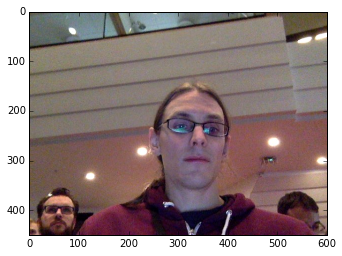

In [73]:
imgur2catdog("http://i.imgur.com/oMJyDO0.jpg") #earlier one while at pycon

WOOF I'm a Dog!


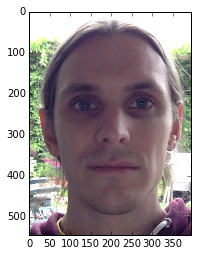

In [74]:
imgur2catdog("http://i.imgur.com/WaKDpDN.jpg") #one now

Another life's mystery solved. Apparently I look more like a dog, than a cat.

What about you?

In [48]:

Image(url='http://image.slidesharecdn.com/catvsdogdlpycon15se-150512122612-lva1-app6891/95/deep-learning-as-a-catdog-detector-62-638.jpg?cb=1431434162')

# FIN

---